In [8]:
# USAGE
# python mixed_training.py -d Pictures

# import the necessary packages
from sklearn.model_selection import train_test_split
from keras.layers.core import Dense
from keras.models import Model
from keras.optimizers import Adam
from keras.optimizers import SGD
from keras.optimizers import RMSprop
from keras.optimizers import Adagrad
from keras.optimizers import Nadam
from keras.optimizers import Adamax
from keras.optimizers import Adadelta
from keras.layers import concatenate
import numpy as np
import argparse
import locale
import os
import matplotlib.pyplot as plt
import pandas as pd
import shap
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [9]:
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt

In [10]:
import keras.backend as K
import keras

In [11]:
# import the necessary packages
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import glob
import cv2
import os

In [12]:
inputPath = '/Users/artemsmirnov/Desktop/for_my_data/Pictures'

In [13]:
cols = ["Y1", "X3_dummy", "X4", "X5", "X6", "X7", "X8", "X9", "X10", "X11", "X12", "X13", "X14_dummy", "logX15", "logX16", "X17", "X18", "X19", "logX20", "logX21", "X22", "X23_dummy", "X24_dummy", "X25", "X26", "X27", "X28", "X29"]

In [14]:
df = pd.read_csv('/Users/artemsmirnov/Desktop/Pictures/alpha_alpha.txt', sep=" ", header=None, names=cols)

In [15]:
df

,Y1,X3_dummy,X4,X5,X6,X7,X8,X9,X10,X11,...,logX20,logX21,X22,X23_dummy,X24_dummy,X25,X26,X27,X28,X29
0,4.789782,1,0.23,0.16,0.56,0.36,-19,32,12.9,0.002594,...,11.315860,9.503696,0.000361,0,1,30,25,6.3,38.9,1241
1,3.519555,1,0.55,0.35,0.13,0.05,-19,32,12.7,0.001288,...,9.473397,9.844799,0.000084,0,1,30,25,6.3,38.9,1241
2,4.242734,1,0.36,0.26,0.57,0.40,-19,32,11.7,0.003204,...,9.630760,10.772420,0.000607,0,1,30,25,6.3,38.9,1241
3,4.182253,1,0.75,0.61,0.17,0.14,-19,31,12.9,0.002246,...,10.426050,10.094350,0.000926,0,1,30,25,6.3,38.9,1241
4,4.124488,1,0.74,0.57,0.26,0.18,-20,30,15.2,0.002367,...,10.292790,10.986290,0.000898,0,1,30,25,6.3,38.9,1241
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,2.890753,1,0.16,0.12,0.48,0.26,-39,31,9.9,0.000414,...,9.810385,6.596873,0.000313,0,0,19,9,5.3,25.0,1095
96,2.868682,1,0.11,0.09,0.22,0.16,-39,30,4.3,0.003284,...,9.734122,8.778911,0.000321,0,0,19,9,5.3,25.0,1095
97,2.812880,1,0.12,0.07,0.20,0.15,-39,31,9.9,0.000360,...,10.031570,8.252368,0.000057,0,0,19,9,5.3,25.0,1095
98,3.486309,0,0.73,0.58,0.31,0.20,-25,31,29.8,0.000583,...,9.848345,8.380617,0.000073,1,1,28,16,5.9,50.9,1314


In [16]:
#now we have to extract our satellite imagery and make an array of the pictures. Every picture contains two parts. 
#The left one is the beginning of summer, the right side is the end of the summer.

def load_field_images(df, inputPath):
    # initialize our images array (i.e., the field images themselves)
    images = []

    # loop over the indexes of the fields
    for i in df.index.values:
         # find the two images for the field and sort the file paths,
        # ensuring the two are always in the *same order*
        basePath = os.path.sep.join([inputPath, "{}_*".format(i + 1)])
        fieldPaths = sorted(list(glob.glob(basePath)))

        # initialize our list of input images along with the output image
        # after *combining* the two input images
        inputImages = []
        outputImage = np.zeros((64, 128, 3), dtype="uint8")


        # loop over the input field paths
        for fieldPath in fieldPaths:
            # load the input image, resize it to be 64 64, and then
            # update the list of input images
            # each photo consists of 64 pixels
            image = cv2.imread(fieldPath)
            image = cv2.resize(image, (64, 64))
            inputImages.append(image)


        # tile the two input images in the output image such the first
        # image goes in the right corner, the second image in the
        # left corner
        
        outputImage[0:64, 0:64] = inputImages[0]
        outputImage[0:64, 64:128] = inputImages[1]

        # add the tiled image to our set of images the network will be
        # trained on
        images.append(outputImage)

    # return our set of images
    return np.array(images)

In [17]:
images = load_field_images(df, inputPath)
images = images / 255.0

In [18]:
split = train_test_split(df, images, test_size=0.25, random_state=42)
(trainAttrX, testAttrX, trainImagesX, testImagesX) = split
trainY = trainAttrX["Y1"]
testY = testAttrX["Y1"] 

In [19]:
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
datagen = ImageDataGenerator(zca_whitening=True)
# fit parameters from data
datagen.fit(trainImagesX)

In [292]:
def process_field_attributes(df, train, test):
    # initialize the column names of the continuous data
    continuous = ["X3_dummy", "X4", "X5", "X6", "X7", "X8", "X9", "X10", "X11", "X12", "X13", "X14_dummy", "logX15", "logX16", "X17", "X18", "X19", "logX20", "logX21", "X22", "X23_dummy", "X24_dummy", "X25", "X26", "X27", "X28", "X29"]

    # performin min-max scaling each continuous feature column to
    # the range [0, 1]
    cs = StandardScaler()
    trainContinuous = cs.fit_transform(train[continuous])
    testContinuous = cs.transform(test[continuous])

    # one-hot encode the zip code categorical data (by definition of
    # one-hot encoing, all output features are now in the range [0, 1])
    #zipBinarizer = LabelBinarizer().fit(df[["No"]])
    #trainCategorical = zipBinarizer.transform(train[["No"]])
    #testCategorical = zipBinarizer.transform(test[["No"]])

    # construct our training and testing data points by concatenating
    # the categorical features with the continuous features
    trainX = np.hstack([trainContinuous])
    testX = np.hstack([testContinuous])

    # return the concatenated training and testing data
    return (trainX, testX)

In [293]:
(trainAttrX, testAttrX) = process_field_attributes(df, trainAttrX, testAttrX)

In [294]:
# import the necessary packages
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras.layers import Flatten
from keras.layers import Input
from keras.models import Model

In [295]:
def create_cnn(width, height, depth, filters=(3, 32, 64), regress=False):
    # initialize the input shape and channel dimension, assuming
    # TensorFlow/channels-last ordering
    inputShape = (height, width, depth)
    chanDim = -1

    # define the model input
    inputs = Input(shape=inputShape)

    # loop over the number of filters
    for (i, f) in enumerate(filters):
        # if this is the first CONV layer then set the input
        # appropriately
        if i == 0:
            x = inputs

        # CONV => RELU => BN => POOL
        x = Conv2D(f, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=chanDim)(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)

    # flatten the volume, then FC => RELU => BN => DROPOUT
    x = Flatten()(x)
    x = Dense(3)(x)
    x = Activation("relu")(x)
    x = BatchNormalization(axis=chanDim)(x)
    x = Dropout(0.5)(x)

    # apply another FC layer, this one to match the number of nodes
    # coming out of the MLP
    x = Dense(4)(x)
    x = Activation("relu")(x)

    # check to see if the regression node should be added
    #if regress:
    x = Dense(1, activation="linear")(x)

    # construct the CNN
    model = Model(inputs, x)

    # return the CNN
    return model

In [296]:
def create_mlp(dim, regress=False):
    # define our MLP network
    model = Sequential()
    model.add(Dense(70, input_dim=dim, activation="sigmoid"))
    model.add(Dense(25, activation="sigmoid"))

    # check to see if the regression node should be added
   # if regress:
    model.add(Dense(1, activation="linear"))

    # return our model
    return model

In [297]:
# create the MLP and CNN models
cnn = create_cnn(128, 64, 3, regress=False)
mlp = create_mlp(trainAttrX.shape[1], regress=False)

In [298]:
trainAttrX

array([[ 0.75      ,  0.72237294, -0.23233494, ..., -0.17514236,
        -0.77820356,  0.21290604],
       [ 0.75      ,  1.77749005,  1.88693646, ..., -0.96328299,
         2.03551099,  1.0533246 ],
       [ 0.75      , -1.02086404, -0.93875874, ..., -1.48871007,
        -0.12009386, -0.62751253],
       ...,
       [-1.33333333,  0.67649828,  0.53295751, ..., -1.22599653,
         1.90940613, -1.46793109],
       [ 0.75      , -0.88324007, -0.82102144, ...,  1.40113889,
         2.32318768,  0.21290604],
       [-1.33333333,  0.40125034,  0.29748291, ...,  1.40113889,
         0.20699061, -1.46793109]])

In [299]:
combinedInput = concatenate([mlp.output, cnn.output])
x = Dense(4, activation="relu")(combinedInput)
x = Dense(1, activation="linear")(x)

In [303]:
gateFactor = Input(tensor = K.variable([0.3]))
model = Model(inputs=[mlp.input, cnn.input, gateFactor], outputs=x)
opt = Adam(lr=1e-3, beta_1=0.9, beta_2=0.999, amsgrad=True)
#opt = SGD(lr=0.001, momentum=0.0, nesterov=False)
#opt = RMSprop(lr=0.001, rho=0.9)
#opt = Adagrad(lr=0.01)
#opt = Nadam(lr=0.002, beta_1=0.9, beta_2=0.999)
#opt = Adamax(lr=0.002, beta_1=0.9, beta_2=0.999)
#opt = Adadelta(lr=0.001, rho=0.95)
model.compile(loss="mean_squared_error", optimizer=opt)
filepath="weights-improvement-{epoch:02d}-{val_loss:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]
print("[INFO] training model...")

history = model.fit(
    [trainAttrX, trainImagesX], trainY,
    validation_data=([testAttrX, testImagesX], testY),
    epochs=100, batch_size=10, callbacks=callbacks_list, verbose=0)

[INFO] training model...

Epoch 00001: val_loss improved from inf to 0.20465, saving model to weights-improvement-01-0.20.hdf5

Epoch 00002: val_loss improved from 0.20465 to 0.19584, saving model to weights-improvement-02-0.20.hdf5

Epoch 00003: val_loss did not improve from 0.19584

Epoch 00004: val_loss did not improve from 0.19584

Epoch 00005: val_loss did not improve from 0.19584

Epoch 00006: val_loss did not improve from 0.19584

Epoch 00007: val_loss did not improve from 0.19584

Epoch 00008: val_loss did not improve from 0.19584

Epoch 00009: val_loss did not improve from 0.19584

Epoch 00010: val_loss did not improve from 0.19584

Epoch 00011: val_loss did not improve from 0.19584

Epoch 00012: val_loss did not improve from 0.19584

Epoch 00013: val_loss did not improve from 0.19584

Epoch 00014: val_loss did not improve from 0.19584

Epoch 00015: val_loss did not improve from 0.19584

Epoch 00016: val_loss did not improve from 0.19584

Epoch 00017: val_loss did not improve 

In [304]:
model.load_weights('weights-improvement-02-0.20.hdf5')

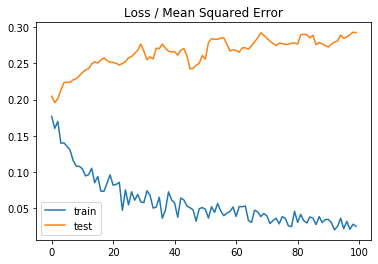

In [305]:
# plot loss during training
plt.title('Loss / Mean Squared Error')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [306]:
# make predictions on the testing data
print("[INFO] predicting FIELD ...")
preds = model.predict([testAttrX, testImagesX])
pd.DataFrame(preds).to_excel('predictions_combinedNNN.xlsx')

preds_trainY = model.predict([trainAttrX, trainImagesX])
pd.DataFrame(preds_trainY).to_excel('preds_trainY.xlsx')
pd.DataFrame(preds).to_excel('preds_testY.xlsx')

pd.DataFrame(trainY).to_excel('real_trainY.xlsx')
pd.DataFrame(testY).to_excel('real_testY.xlsx')

# compute the difference between the *predicted* field productivities and the
# *actual* field productivities, then compute the percentage difference and
# the absolute percentage difference
diff = preds.flatten() - testY
percentDiff = (diff / testY) * 100
absPercentDiff = np.abs(percentDiff)

# compute the mean and standard deviation of the absolute percentage
# difference
mean = np.mean(absPercentDiff)
std = np.std(absPercentDiff)

# finally, show some statistics on our model
locale.setlocale(locale.LC_ALL, "en_US.UTF-8")
print("[INFO] avg. FIELD...: {}, std FIELD: {}".format(locale.currency(df["Y1"].mean(), grouping=True),locale.currency(df["Y1"].std(), grouping=True)))
print("[INFO] mean: {:.2f}, std: {:.2f}".format(mean, std))

[INFO] predicting FIELD ...
[INFO] avg. FIELD...: $3.31, std FIELD: $0.81
[INFO] mean: 10.71, std: 11.80


In [307]:
preds

array([[2.2263587],
       [2.8335798],
       [3.7714376],
       [4.0549097],
       [3.8338733],
       [3.1861143],
       [3.7451522],
       [2.3346887],
       [3.205491 ],
       [4.1772494],
       [3.9647622],
       [4.2032213],
       [2.4094718],
       [1.7206302],
       [2.7959483],
       [4.075006 ],
       [3.6642587],
       [2.3212838],
       [3.6477196],
       [3.7658844],
       [3.7787287],
       [1.7156134],
       [3.8629441],
       [3.975269 ],
       [3.8254561]], dtype=float32)

In [308]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_49 (InputLayer)           (None, 64, 128, 3)   0                                            
__________________________________________________________________________________________________
conv2d_37 (Conv2D)              (None, 64, 128, 3)   84          input_49[0][0]                   
__________________________________________________________________________________________________
activation_61 (Activation)      (None, 64, 128, 3)   0           conv2d_37[0][0]                  
__________________________________________________________________________________________________
batch_normalization_49 (BatchNo (None, 64, 128, 3)   12          activation_61[0][0]              
__________________________________________________________________________________________________
max_poolin

# CNN Part (Images)

In [309]:
import random

In [310]:
#i = history.history['val_loss'][-1]
#lernen = random.choice([0.01, 0.001, 0.0001, 0.00001])
#epokhi = int(random.uniform(25, 150))
#batsch = int(random.uniform(1, 15))
#    
#while i > 0.423642161533107:
#    gateFactor = Input(tensor = K.variable([0.3]))
#    model = Model(inputs=[mlp.input, cnn.input, gateFactor], outputs=x)
#    opt = Adam(lr=lernen, beta_1=0.9, beta_2=0.999, amsgrad=True)
#    model.compile(loss="mean_squared_error", optimizer=opt)
#    history = model.fit(
#    [trainAttrX, trainImagesX], trainY,
#        validation_data=([testAttrX, testImagesX], testY),
#        epochs=epokhi, batch_size=batsch)
#    i = history.history['val_loss'][-1]
#    lernen = random.choice([0.01, 0.001, 0.0001, 0.00001])
#    epokhi = int(random.uniform(25, 150))
#    batsch = int(random.uniform(1, 15)

#if i < 0.423642161533107:
#    preds = model.predict([testAttrX, testImagesX])
#    pd.DataFrame(preds).to_excel('predictions_combinedNACHT.xlsx')

Lime

In [311]:
%load_ext autoreload
%autoreload 2
import os,sys
try:
    import lime
except:
    sys.path.append(os.path.join('..', '..')) # add the current directory
    import lime
from lime import lime_image

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [312]:
import time

In [313]:
explainer = lime_image.LimeImageExplainer()

In [314]:
inet_model = cnn

In [315]:
#Select the 16th observation for the cheque of the LIME
time
# Hide color is the color for a superpixel turned OFF. Alternatively, if it is NONE, the superpixel will be replaced by the average of its pixels
explanation = explainer.explain_instance(images[45], inet_model.predict, top_labels=5, hide_color=0, num_samples=1000)

100% |########################################################################|


In [316]:
from skimage.segmentation import mark_boundaries

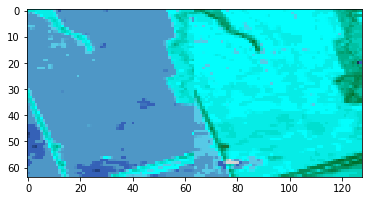

In [317]:
#Just field before the lIME

# I'm dividing by 2 and adding 0.5 because of how this Inception represents images
plt.imshow(images[45])
#preds = inet_model.predict(images)
#for x in decode_predictions(preds)[0]:
#    print(x)

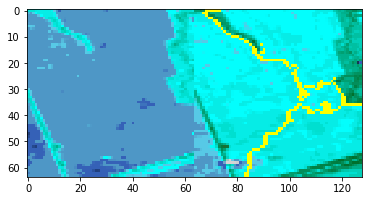

In [318]:
#There are several examples of division of the field into sectors.
#The number of superpixels is 5.

temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
plt.imshow(mark_boundaries(temp, mask))

In [319]:
def transform_img_fn(path_list):
    out = []
    for img_path in path_list:
        img = image.load_img(img_path, target_size=(128, 64))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = inc_net.preprocess_input(x)
        out.append(x)
    return np.vstack(out)

In [320]:
from keras.applications.resnet50 import preprocess_input, decode_predictions

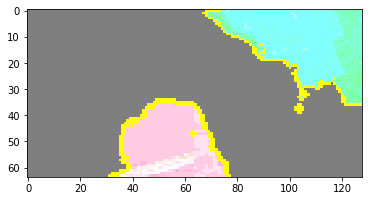

In [410]:
#Grey is for the part which don't have the positive impact on Y_i

temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=2, hide_rest=True)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

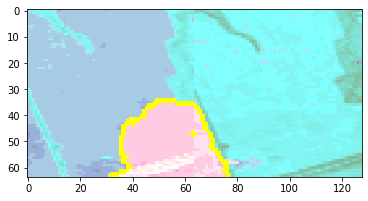

In [322]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=1, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

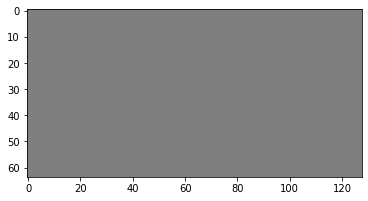

In [323]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=0, hide_rest=True, min_weight=0.1)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

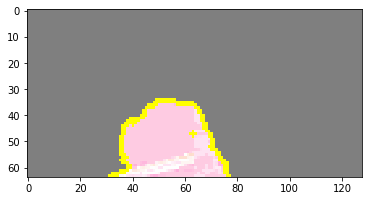

In [324]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=1, hide_rest=True)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

Final picture

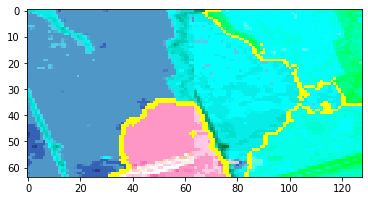

In [416]:
#Дивеевский район, Нижегородская область
#For my thesis I would prefer this image. The green part has positive impact on Y_i, the orange one reduces the probability of a high level of the crop. Others don't the impact. 

temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=3, hide_rest=False)
plot = plt.imshow(mark_boundaries(temp, mask))

In [326]:
#Часть изображения, ответственная за весенний снимок, показывает недостаточную растительность для данного времени года,
#следоватлеьно, прогнозное значение урожайности для данного наблюдения по МО уменьшается из-за данного участка.

SHAP

In [327]:
import shap
import numpy as np

In [328]:
cnn.layers

[<keras.engine.input_layer.InputLayer at 0x170187290>,
 <keras.layers.convolutional.Conv2D at 0x171c19e50>,
 <keras.layers.core.Activation at 0x172cd7350>,
 <keras.layers.normalization.BatchNormalization at 0x164045690>,
 <keras.layers.pooling.MaxPooling2D at 0x1731d4f90>,
 <keras.layers.convolutional.Conv2D at 0x1701a66d0>,
 <keras.layers.core.Activation at 0x170639c10>,
 <keras.layers.normalization.BatchNormalization at 0x164f34fd0>,
 <keras.layers.pooling.MaxPooling2D at 0x164f34390>,
 <keras.layers.convolutional.Conv2D at 0x164f46d10>,
 <keras.layers.core.Activation at 0x164e9d7d0>,
 <keras.layers.normalization.BatchNormalization at 0x16fd16d90>,
 <keras.layers.pooling.MaxPooling2D at 0x16fd7cb90>,
 <keras.layers.core.Flatten at 0x151751a10>,
 <keras.layers.core.Dense at 0x16fe0cf10>,
 <keras.layers.core.Activation at 0x1706e2310>,
 <keras.layers.normalization.BatchNormalization at 0x1706e2f90>,
 <keras.layers.core.Dropout at 0x1706e2c50>,
 <keras.layers.core.Dense at 0x170713910>,
 <keras.layers.core.Activation at 0x170ae3dd0>,
 <keras.layers.core.Dense at 0x170ae3f90>]

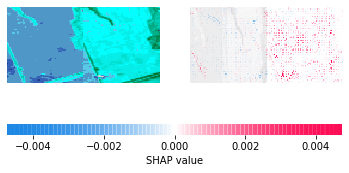

In [418]:
# select a train set of background examples to take an expectation over
background = trainImagesX[np.random.choice(trainImagesX.shape[0], 75, replace=False)]

# explain predictions of the model on all test images
e = shap.DeepExplainer((cnn.layers[4].input, cnn.layers[-1].output), background)
shap_values = e.shap_values(testImagesX[3:4])

# plot the feature attributions
shap.image_plot(shap_values, testImagesX[3:4], labels=None, show=True, width=200, aspect=0.2, hspace=0.2, labelpad=None)

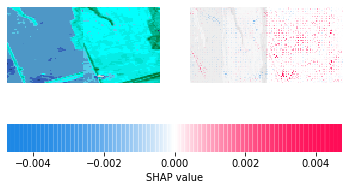

In [424]:
# plot the feature attributions
shap.image_plot(shap_values, testImagesX[3:4], labels=None, show=True, width=20, aspect=0.5, hspace=0.2, labelpad=None)

In [331]:
#red pixels are the sectors which positively influence on Y_i
#blau pixels have the opposite effect
#Выберем 4-е по счету поле для примера.
#Для данного изображения (Дивеевский район, Нижегородская область) позитивное воздействие на урожайность
#оказывает река в северной части поля в оба сезона года. Негативное влияние на урожайность выявлено у юго-западного 
#участка с низкой урожайностью весной.

In [332]:
#Интерпретаторы LIME и SHAP приходят к похожим вывожам, однако для SHAP объяснения более детальны, так как, 
#в отличие от lIME, здесь нет суперпикселей, искуственно укркупненных секторов изображения, которые 
#несколько упрощают фогорафию. Также SHAP, согласно теории, является единственным на данный момент методом,
#который предоставляет полное, а не локальное объяснение модели глубокого обучения.

# MLP Part (Tabular Data)

In [378]:
import lime
import lime.lime_tabular
import pandas as pd

In [379]:
preds = mlp.predict([testAttrX])
preds = pd.DataFrame(data=preds)
preds

,0
0,1.821822
1,2.479917
2,3.392828
3,3.614573
4,3.443816
5,2.775616
6,3.372358
7,1.958133
8,2.859366
9,3.783774


In [380]:
trainAttrX=pd.DataFrame(data=trainAttrX)
trainAttrX

,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,24,25,26
0,0.750000,0.722373,-0.232335,-1.077750,-1.017155,0.358515,0.053792,-0.372564,0.977890,0.706437,...,0.239928,0.794243,-0.655469,2.087377,0.479070,-0.129156,0.772286,-0.175142,-0.778204,0.212906
1,0.750000,1.777490,1.886936,-0.947061,-1.017155,1.318824,2.226145,-0.686169,0.216393,1.566541,...,0.637138,0.503142,2.499032,2.087377,0.479070,-0.205429,0.307675,-0.963283,2.035511,1.053325
2,0.750000,-1.020864,-0.938759,-0.228270,-0.190946,-1.802179,-0.566881,-1.391782,3.230832,0.448274,...,-0.297041,-0.256842,0.055999,-0.479070,-2.087377,-0.891887,-1.395896,-1.488710,-0.120094,-0.627513
3,-1.333333,-0.195120,-0.055729,1.928101,2.379482,0.358515,-0.256545,-0.592087,0.366972,-0.439920,...,1.963341,0.587559,-0.932909,-0.479070,0.479070,-0.281702,2.166117,-0.437856,-1.105288,0.212906
4,0.750000,-1.341987,-1.409708,-1.143095,-0.925354,0.118438,0.053792,-0.921373,0.891846,0.948761,...,-0.533247,-0.803596,-0.661967,-0.479070,0.479070,-0.205429,-0.156935,-1.488710,-0.194969,0.212906
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,0.750000,0.951746,1.180513,-0.358960,-0.099145,-0.001601,-0.566881,-0.654809,-0.685644,-1.478014,...,-1.372971,0.410549,-0.855590,-0.479070,-2.087377,-0.968160,0.152805,-0.175142,-1.105288,-2.308350
71,-1.333333,-1.066739,-0.997627,-1.143095,-1.476160,0.238477,-1.808226,-0.811611,-1.024087,-1.240421,...,-1.148616,0.112418,-0.047960,-0.479070,0.479070,-0.205429,-0.156935,-1.488710,-0.194969,0.212906
72,-1.333333,0.676498,0.532958,0.686554,0.635263,0.238477,0.053792,-0.231441,-1.209084,-0.204089,...,0.563373,-0.225601,-0.986838,-0.479070,-2.087377,-1.654618,-1.550766,-1.225997,1.909406,-1.467931
73,0.750000,-0.883240,-0.821021,0.686554,2.195880,-1.802179,-0.566881,-0.560727,0.124612,-1.944678,...,1.329994,1.294855,-0.288364,2.087377,0.479070,1.930218,-0.002065,1.401139,2.323188,0.212906


In [381]:
testAttrX=pd.DataFrame(data=testAttrX)
testAttrX

,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,24,25,26
0,-1.333333,-0.883240,-0.938759,-0.554993,-0.741752,-1.562102,0.984800,-0.576407,-0.648358,0.116204,...,0.181716,-0.665206,0.923406,-0.479070,-2.087377,2.159037,0.927156,1.401139,0.155761,0.212906
1,-1.333333,0.859997,0.827301,2.385513,2.195880,-0.121639,-0.256545,0.176246,0.235036,-1.353431,...,-1.466002,0.523579,-0.986838,-0.479070,0.479070,-0.129156,0.152805,0.875712,-0.317133,-0.627513
2,0.750000,0.034253,-0.408941,-0.685683,-0.649951,-0.241678,0.053792,0.866179,1.168623,0.122044,...,0.869808,1.736928,-0.587246,-0.479070,0.479070,-0.434248,-0.621545,0.350285,0.805989,0.212906
3,-1.333333,2.190362,2.593360,-1.208439,-1.017155,1.798978,-2.739235,-0.137359,-0.133523,1.421442,...,0.957135,0.588011,-0.986838,-0.479070,0.479070,-0.205429,0.307675,-0.963283,0.206991,1.053325
4,0.750000,1.456367,2.063542,-0.816372,-0.649951,2.039055,1.295137,0.176246,0.435808,-0.100361,...,1.123559,0.668061,-0.986838,-0.479070,0.479070,-0.205429,0.307675,-0.963283,0.206991,1.053325
5,0.750000,0.217752,0.003140,0.033108,-0.466349,1.078747,1.915809,-0.811611,-0.588126,0.851736,...,0.983655,0.168663,1.352236,2.087377,0.479070,-0.205429,0.307675,-0.963283,2.035511,1.053325
6,-1.333333,1.272869,1.121644,-0.293615,0.176258,0.118438,0.053792,0.803458,0.239339,0.224586,...,-0.214153,0.462359,-0.986838,-0.479070,0.479070,-0.357975,1.546636,0.350285,-1.105288,-0.627513
7,0.750000,-1.020864,-0.997627,0.621209,0.359860,-0.601793,-1.187553,-0.184400,-0.611072,0.321439,...,-0.123369,-0.627671,0.582291,2.087377,0.479070,-0.052883,-1.395896,0.087571,0.983324,-0.627513
8,-1.333333,-0.332744,-0.232335,0.490520,0.359860,0.598592,-0.877217,-0.780251,-1.194743,-2.111510,...,0.145644,0.303927,-0.301359,-0.479070,0.479070,-0.281702,2.166117,-0.437856,-1.105288,0.212906
9,0.750000,-0.470368,-0.526678,1.993446,1.645074,0.598592,0.053792,-0.043278,2.241316,-0.441122,...,2.514444,0.185716,0.185948,-0.479070,0.479070,-0.052883,1.082026,1.138425,0.427674,1.053325


In [382]:
explainer = lime.lime_tabular.LimeTabularExplainer(testAttrX.as_matrix(), 
                                                   feature_names=cols[1:], 
                                                   class_names=['Y1'], 
                                                   verbose = True,
                                                   mode='regression')

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


In [385]:
qc = testAttrX.as_matrix()[2]
qc_reshape = qc.reshape(1,-1)
def predict(qc):
    global mlp
    qc = mlp.predict(qc)
    return qc.reshape(qc.shape)
exp = explainer.explain_instance(qc, predict, num_features=len(df.columns[1:]))

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


Intercept 2.954999515299291
Prediction_local [3.35015821]
Right: 3.3928285


In [384]:
results = pd.DataFrame([])
variables = ['X1','X2','logX3','X4','X5', 'logX6','X7','X8','X9','X10', 'X11', 'X12', 'X13','X14']
for i in range (0, 25):
    qc = testAttrX.as_matrix()[2]
    qc_reshape = qc.reshape(1,-1)
    def predict(qc):
        global mlp
        qc = mlp.predict(qc)
        return qc.reshape(qc.shape[0])
    exp = explainer.explain_instance(qc, predict, num_features=len(df.columns[1:]))
    #results.append(exp.as_list())
    values = []
    for var in variables:
        for item in exp.as_list():
            if var in item[0]:
                values.append(item[1])
    results[i] = values
results.head()
results = results.T
# results.columns = variables
# results.head()
#     exp.show_in_notebook(show_all=False)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


Intercept 3.2286700972803493
Prediction_local [2.84795788]
Right: 2.7756162


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


Intercept 3.256047658733188
Prediction_local [2.81992382]
Right: 2.7756162


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


Intercept 3.252465965786702
Prediction_local [2.82925872]
Right: 2.7756162


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


Intercept 3.286757522972826
Prediction_local [2.74820667]
Right: 2.7756162


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


Intercept 3.2451570374593115
Prediction_local [2.84331917]
Right: 2.7756162


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


Intercept 3.240682293288305
Prediction_local [2.81660011]
Right: 2.7756162


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


Intercept 3.2348497058809755
Prediction_local [2.83251169]
Right: 2.7756162


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


Intercept 3.241333119799723
Prediction_local [2.84762959]
Right: 2.7756162


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


Intercept 3.2507120473837148
Prediction_local [2.82385387]
Right: 2.7756162


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


Intercept 3.228389946686169
Prediction_local [2.83327199]
Right: 2.7756162


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


Intercept 3.2731112405761227
Prediction_local [2.76213176]
Right: 2.7756162


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


Intercept 3.2669560777886355
Prediction_local [2.8029117]
Right: 2.7756162


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


Intercept 3.2352381348231356
Prediction_local [2.84214822]
Right: 2.7756162


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


Intercept 3.212876663760771
Prediction_local [2.88956976]
Right: 2.7756162


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


Intercept 3.2281200659730924
Prediction_local [2.86979388]
Right: 2.7756162


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


Intercept 3.2670231213134624
Prediction_local [2.7787723]
Right: 2.7756162


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


Intercept 3.211778421945466
Prediction_local [2.91300513]
Right: 2.7756162


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


Intercept 3.2502003927766645
Prediction_local [2.83208695]
Right: 2.7756162


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


Intercept 3.2426860883367143
Prediction_local [2.84916523]
Right: 2.7756162


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


Intercept 3.2318589498843164
Prediction_local [2.83988856]
Right: 2.7756162


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


Intercept 3.249389301460731
Prediction_local [2.84901602]
Right: 2.7756162


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


Intercept 3.2569863326367248
Prediction_local [2.82415548]
Right: 2.7756162


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


Intercept 3.2842735202772597
Prediction_local [2.76311524]
Right: 2.7756162


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


Intercept 3.255378042030239
Prediction_local [2.80124354]
Right: 2.7756162


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


Intercept 3.2540456056486
Prediction_local [2.79716]
Right: 2.7756162


In [386]:
results

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,0.267918,-0.161784,-0.142391,0.126992,-0.051811,-0.048941,-0.046375,0.017151,0.013164,-0.009312,...,-0.020223,-0.007633,0.004570,0.069869,-0.221112,-0.009312,-0.051811,0.267918,0.017151,-0.048941
1,0.256552,-0.152120,0.136150,-0.130836,-0.083001,-0.062106,-0.056927,-0.023084,0.016305,-0.010412,...,0.030703,0.003501,-0.005248,0.086787,-0.224842,0.016305,-0.062106,0.256552,-0.010412,-0.083001
2,0.261733,-0.165754,-0.133891,0.117604,-0.076490,-0.066014,-0.040586,-0.034779,-0.010863,0.002314,...,0.009788,-0.003957,0.021120,0.053850,-0.231734,-0.010863,-0.040586,0.261733,0.002314,-0.066014
3,0.243686,-0.170259,-0.152990,0.119296,-0.082908,-0.063782,-0.059033,-0.026611,-0.019724,-0.007711,...,0.003827,0.002796,-0.006280,0.087952,-0.206961,-0.026611,-0.059033,0.243686,-0.007711,-0.082908
4,0.247069,-0.133481,0.108806,-0.099078,-0.084500,-0.063726,-0.052927,-0.006239,-0.002217,0.000322,...,-0.005167,-0.020965,-0.000225,0.072758,-0.229940,-0.006239,-0.052927,0.247069,0.000322,-0.084500
5,0.262315,-0.139007,-0.119766,0.102113,-0.084126,-0.073947,-0.033411,-0.028151,0.027716,0.001847,...,0.008776,-0.002280,0.011642,0.082880,-0.215845,-0.028151,-0.033411,0.262315,0.027716,-0.073947
6,0.254568,-0.157317,-0.134412,0.117103,-0.079334,-0.073453,-0.056334,0.005185,0.003808,-0.001395,...,-0.013224,-0.021972,0.025753,0.075319,-0.234388,-0.001395,-0.056334,0.254568,0.005185,-0.079334
7,0.250923,-0.136164,0.133800,-0.116418,-0.065099,-0.053078,-0.044006,-0.029736,-0.025511,0.001552,...,0.010082,0.012509,-0.005234,0.054593,-0.208903,-0.025511,-0.053078,0.250923,0.001552,-0.065099
8,0.269499,-0.156660,-0.141172,0.134494,-0.078696,-0.063661,-0.043321,-0.024120,-0.015336,0.009923,...,0.000144,0.017284,0.031546,0.068495,-0.217498,-0.015336,-0.043321,0.269499,0.009923,-0.078696
9,0.251641,-0.137275,-0.126501,0.102932,-0.081125,-0.065698,-0.064972,0.019620,-0.013753,-0.001794,...,0.011465,-0.011661,0.030850,0.076186,-0.228168,-0.013753,-0.065698,0.251641,0.019620,-0.081125


In [393]:
results = pd.DataFrame([])
variables = ["X3_dummy", "X4", "X5", "X6", "X7", "X8", "X9", "X10", "X11", "X12", "X13", "X14_dummy", "logX15", "logX16", "X17", "X18", "X19", "logX20", "logX21", "X22", "X23_dummy", "X24_dummy", "X25", "X26", "X27", "X28", "X29"]
for i in range (0, 25):
    qc = testAttrX.as_matrix()[2]
    qc_reshape = qc.reshape(1,-1)
    def predict(qc):
        global mlp
        qc = mlp.predict(qc)
        return qc.reshape(qc.shape)
    exp = explainer.explain_instance(qc, predict, num_features=len(df.columns))
    #results.append(exp.as_list())
    values = []
    for var in variables:
        for item in exp.as_list():
            if var in item[0]:
                values.append(item[1])
    results[i] = values
results.head()
results = results.T
results.columns = variables
results.head()
#     exp.show_in_notebook(show_all=False)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


Intercept 3.001604030158598
Prediction_local [3.24583013]
Right: 3.3928285


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


Intercept 3.0031719938831962
Prediction_local [3.27079217]
Right: 3.3928285


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


Intercept 2.938726095432664
Prediction_local [3.42853712]
Right: 3.3928285


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


Intercept 2.9571824936683
Prediction_local [3.38923009]
Right: 3.3928285


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


Intercept 2.999991315400895
Prediction_local [3.28429061]
Right: 3.3928285


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


Intercept 2.920622517507827
Prediction_local [3.43305237]
Right: 3.3928285


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


Intercept 3.0205296336662206
Prediction_local [3.33395192]
Right: 3.3928285


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


Intercept 2.994775031008145
Prediction_local [3.30616563]
Right: 3.3928285


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


Intercept 3.0027863469867238
Prediction_local [3.27558255]
Right: 3.3928285


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


Intercept 3.0245946863416617
Prediction_local [3.22070507]
Right: 3.3928285


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


Intercept 2.962442030081261
Prediction_local [3.34137097]
Right: 3.3928285


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


Intercept 2.9691052238589704
Prediction_local [3.35044255]
Right: 3.3928285


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


Intercept 2.9833694393539516
Prediction_local [3.28157468]
Right: 3.3928285


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


Intercept 2.9818296037897722
Prediction_local [3.30534823]
Right: 3.3928285


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


Intercept 2.981837756203749
Prediction_local [3.34172092]
Right: 3.3928285


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


Intercept 2.9764442541379124
Prediction_local [3.35955796]
Right: 3.3928285


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


Intercept 2.960295715623937
Prediction_local [3.41113489]
Right: 3.3928285


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


Intercept 2.9932951869440436
Prediction_local [3.34065217]
Right: 3.3928285


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


Intercept 2.971138188057175
Prediction_local [3.33806288]
Right: 3.3928285


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


Intercept 2.9671067361571373
Prediction_local [3.32943184]
Right: 3.3928285


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


Intercept 2.997524299059807
Prediction_local [3.24898299]
Right: 3.3928285


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


Intercept 3.000421286271431
Prediction_local [3.31981993]
Right: 3.3928285


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


Intercept 2.9691806738536486
Prediction_local [3.41131246]
Right: 3.3928285


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


Intercept 2.9466585264113725
Prediction_local [3.3810846]
Right: 3.3928285


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


Intercept 2.996913706445763
Prediction_local [3.34475788]
Right: 3.3928285


,X3_dummy,X4,X5,X6,X7,X8,X9,X10,X11,X12,...,logX20,logX21,X22,X23_dummy,X24_dummy,X25,X26,X27,X28,X29
0,-0.016803,0.005776,-0.031807,0.059788,0.024051,-0.275570,-0.019973,0.011821,0.211037,0.012266,...,0.116895,0.062800,-0.044588,0.084555,0.0,0.081416,0.004382,0.108978,0.006806,-0.019153
1,-0.005428,-0.003168,0.006470,0.058917,0.004273,-0.275199,-0.028668,0.015066,0.211462,0.018141,...,0.116351,0.077886,-0.068573,0.083582,0.0,0.052840,-0.008268,0.133288,-0.017601,-0.021520
2,-0.016249,0.048235,-0.021468,0.068224,0.024606,-0.259999,-0.009765,0.037243,0.236480,0.019060,...,0.118241,0.109209,-0.031255,0.093847,0.0,0.078703,-0.009141,0.113298,-0.004090,0.001586
3,-0.013316,0.021311,-0.003590,0.072228,0.030711,-0.277774,-0.015021,0.029458,0.236377,0.018665,...,0.130372,0.064272,-0.043322,0.068479,0.0,0.045811,0.004014,0.116494,0.009465,0.011330
4,-0.015392,-0.000346,0.011962,0.053742,0.045273,-0.271752,-0.037428,0.023224,0.236183,0.010432,...,0.109873,0.063051,-0.068178,0.076952,0.0,0.080069,-0.011082,0.112797,-0.034589,-0.032742


In [394]:
results.head()

,X3_dummy,X4,X5,X6,X7,X8,X9,X10,X11,X12,...,logX20,logX21,X22,X23_dummy,X24_dummy,X25,X26,X27,X28,X29
0,-0.016803,0.005776,-0.031807,0.059788,0.024051,-0.275570,-0.019973,0.011821,0.211037,0.012266,...,0.116895,0.062800,-0.044588,0.084555,0.0,0.081416,0.004382,0.108978,0.006806,-0.019153
1,-0.005428,-0.003168,0.006470,0.058917,0.004273,-0.275199,-0.028668,0.015066,0.211462,0.018141,...,0.116351,0.077886,-0.068573,0.083582,0.0,0.052840,-0.008268,0.133288,-0.017601,-0.021520
2,-0.016249,0.048235,-0.021468,0.068224,0.024606,-0.259999,-0.009765,0.037243,0.236480,0.019060,...,0.118241,0.109209,-0.031255,0.093847,0.0,0.078703,-0.009141,0.113298,-0.004090,0.001586
3,-0.013316,0.021311,-0.003590,0.072228,0.030711,-0.277774,-0.015021,0.029458,0.236377,0.018665,...,0.130372,0.064272,-0.043322,0.068479,0.0,0.045811,0.004014,0.116494,0.009465,0.011330
4,-0.015392,-0.000346,0.011962,0.053742,0.045273,-0.271752,-0.037428,0.023224,0.236183,0.010432,...,0.109873,0.063051,-0.068178,0.076952,0.0,0.080069,-0.011082,0.112797,-0.034589,-0.032742


In [395]:
results.mean()

X3_dummy    -0.011214
X4           0.013106
X5          -0.004351
X6           0.057252
X7           0.021047
X8          -0.268351
X9          -0.025058
X10          0.025483
X11          0.226008
X12          0.019618
X13         -0.000350
X14_dummy   -0.061350
logX15       0.065669
logX16      -0.035491
X17          0.043370
X18         -0.135153
X19          0.014557
logX20       0.110080
logX21       0.068534
X22         -0.047823
X23_dummy    0.084735
X24_dummy    0.000000
X25          0.074311
X26          0.003656
X27          0.120446
X28         -0.007933
X29          0.000078
dtype: float64

In [396]:
exp.show_in_notebook(show_table=True, show_all=False)

In [397]:
pd.DataFrame(results).to_excel('results_lime_combined.xlsx')

In [398]:
testAttrX = testAttrX.as_matrix()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


In [399]:
import sklearn
import shap
from sklearn.model_selection import train_test_split

In [400]:
# print the JS visualization code to the notebook
shap.initjs()

In [401]:
import tensorflow as tf
#tf.compat.v1.Session()

In [402]:
pip install tensorflow==1.14.0

Note: you may need to restart the kernel to use updated packages.


In [403]:
print(tf.__version__)
print(keras.__version__)
print(shap.__version__)

1.14.0
2.2.4
0.30.0


In [404]:
testAttrX_ = pd.DataFrame(testAttrX, columns=["X3_dummy", "X4", "X5", "X6", "X7", "X8", "X9", "X10", "X11", "X12", "X13", "X14_dummy", "logX15", "logX16", "X17", "X18", "X19", "logX20", "logX21", "X22", "X23_dummy", "X24_dummy", "X25", "X26", "X27", "X28", "X29"])

In [405]:
# select a set of background examples to take an expectation over 
background = testAttrX[np.random.choice(testAttrX.shape[0], 25, replace=False)] 
  
# explain predictions of the model on four images 
#e = shap.GradientExplainer(model, trainAttrX) 
 # ...or pass tensors directly 
e = shap.DeepExplainer((mlp.layers[0].input, mlp.layers[-1].output), background) 
shap_values = e.shap_values(testAttrX) 
  
 # plot the feature attributions 
#shap.image_plot(shap_values, trainAttrX) 
shap.force_plot(e.expected_value[0], shap_values[0][2,:], testAttrX_.iloc[2,:], link="identity")

In [374]:
shap.force_plot(e.expected_value[0], shap_values[0], testAttrX_, link="identity") #ДЛя всех наблюдений

In [355]:
sv = np.array(shap_values)

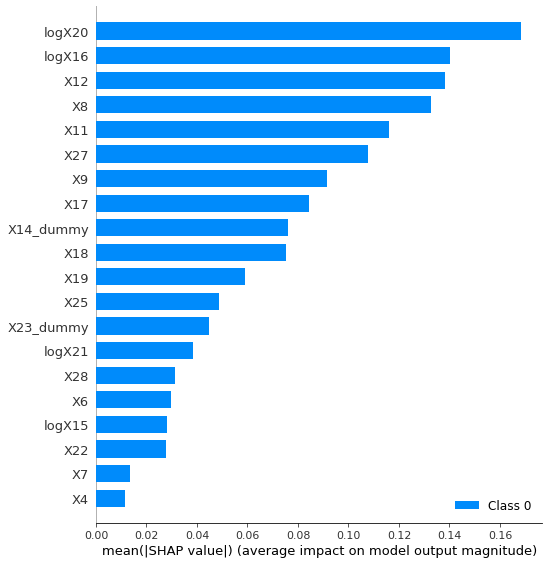

In [356]:
shap.summary_plot(shap_values, testAttrX_)

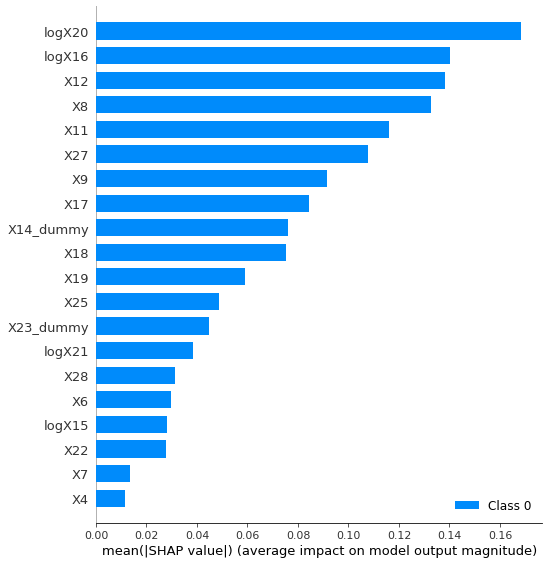

In [357]:
shap.summary_plot(shap_values, testAttrX_, plot_type='bar')

In [358]:
sv=[]
for item in shap_values:
    for item_ in item:
        print(item_)
        a=[]
        for i in item_:
            print(i)
            a.append(i)
        sv.append(a)

[ 0.01027119 -0.01536502 -0.00747674  0.04430666  0.02813012 -0.33121685
 -0.09935633 -0.00582555 -0.123045    0.01842866  0.00526402 -0.09992874
  0.00666145 -0.23863829 -0.14785225 -0.13123663 -0.11918323 -0.06666757
 -0.06378481  0.04738817  0.03443452  0.09412141 -0.20879294 -0.00379743
  0.24986502  0.00050785  0.00125089]
0.010271190277611215
-0.015365023484571376
-0.007476742390396669
0.04430666407143451
0.028130120066883185
-0.3312168543255477
-0.09935632716035786
-0.005825549837450879
-0.12304499896162958
0.018428657505401885
0.005264020938199472
-0.09992873959728382
0.006661454476787179
-0.23863829413085821
-0.14785224592226354
-0.13123663181128895
-0.11918322672003277
-0.0666675657838744
-0.06378481266802696
0.047388170272611635
0.034434523435175474
0.09412141073118269
-0.20879294195146708
-0.0037974337978903937
0.24986502309231934
0.0005078474908931245
0.001250890344244769
[ 8.67154379e-03  2.10467917e-02  1.61493229e-02 -8.25326116e-02
 -3.33480102e-02 -4.80890090e-02  4.0

In [359]:
sv = pd.DataFrame(sv)
sv.columns = results.columns

In [360]:
sv

,X3_dummy,X4,X5,X6,X7,X8,X9,X10,X11,X12,...,logX20,logX21,X22,X23_dummy,X24_dummy,X25,X26,X27,X28,X29
0,0.010271,-0.015365,-0.007477,0.044307,0.028130,-0.331217,-0.099356,-0.005826,-0.123045,0.018429,...,-0.066668,-0.063785,0.047388,0.034435,0.094121,-0.208793,-0.003797,0.249865,0.000508,0.001251
1,0.008672,0.021047,0.016149,-0.082533,-0.033348,-0.048089,0.040573,0.008669,0.025840,-0.364411,...,-0.446552,0.022529,-0.048074,0.040948,-0.007557,0.012922,-0.000441,0.152378,0.024059,0.001675
2,-0.012034,0.005295,0.004817,0.027472,0.009349,-0.038288,0.009878,0.013718,0.128274,0.025835,...,0.088007,0.063979,-0.021642,0.028160,-0.006177,0.036166,0.000430,0.048320,-0.012331,0.003175
3,0.002291,0.004059,-0.014589,0.030715,0.006884,0.169854,0.136780,0.001318,-0.005075,0.186657,...,0.082186,0.017620,-0.033501,0.022088,-0.004682,0.017383,0.000705,-0.077423,0.005748,0.009524
4,-0.006626,0.014361,0.001133,0.027815,0.010992,0.216138,-0.067367,0.003619,0.048107,-0.011318,...,0.119070,0.023538,-0.039254,0.025006,-0.005262,0.018883,0.000361,-0.094140,0.004918,0.009386
5,-0.012837,0.008361,0.004398,0.016306,0.017245,0.159034,-0.175145,-0.010026,-0.090608,0.210308,...,0.131519,0.001413,0.071949,-0.091709,-0.006945,0.020778,-0.001489,-0.132189,-0.060910,0.001770
6,0.005769,0.012626,0.004192,0.020516,0.003271,0.008174,0.009829,0.012138,0.029653,0.043440,...,-0.100862,0.016699,-0.040233,0.028075,-0.005551,0.031395,-0.006749,0.049095,0.043079,-0.004890
7,-0.012003,-0.018173,-0.002531,-0.009159,0.000504,-0.148187,0.152798,0.001007,-0.114690,0.078025,...,-0.137588,-0.061523,0.035624,-0.094983,-0.006473,0.002623,0.013439,0.029705,-0.027200,0.001800
8,0.008288,0.000298,0.005335,-0.002238,0.001057,0.080403,0.098108,-0.009494,-0.174800,-0.520389,...,-0.055492,0.009088,-0.012524,0.038177,-0.007070,0.029729,-0.006616,-0.052862,0.053033,0.002346
9,-0.009112,0.002778,0.005915,-0.030922,-0.009557,0.053775,0.009289,0.002284,0.172280,-0.049772,...,0.252395,0.005541,0.006891,0.024990,-0.004000,0.008723,-0.000850,0.095915,0.001082,0.003007


In [1]:
sv.mean()

NameError: name 'sv' is not defined

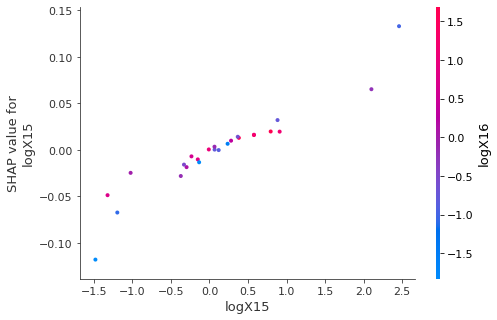

In [362]:
shap.dependence_plot("logX15", shap_values[0], testAttrX_)

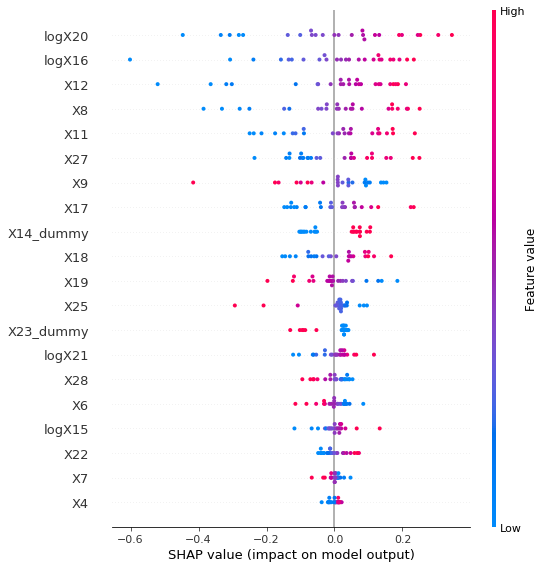

In [363]:
shap.summary_plot(shap_values[0], testAttrX_)